In [ ]:
import torch
from torch import nn
import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

torch.manual_seed(45)

In [ ]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Device: ", device)

Device:  cuda


In [ ]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
train_set = torchvision.datasets.CelebA(
    root=".", split='train', transform=transform, download=True
    )

Downloading...
From (original): https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM
From (redirected): https://drive.usercontent.google.com/download?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM&confirm=t&uuid=6f7c1413-8744-4184-9d98-e37f4be387b4
To: /content/celeba/img_align_celeba.zip
100%|██████████| 1.44G/1.44G [00:15<00:00, 95.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pblRyaVFSWGxPY0U
To: /content/celeba/list_attr_celeba.txt
100%|██████████| 26.7M/26.7M [00:00<00:00, 30.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_ee_0u7vcNLOfNLegJRHmolfH5ICW-XS
To: /content/celeba/identity_CelebA.txt
100%|██████████| 3.42M/3.42M [00:00<00:00, 190MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pbThiMVRxWXZ4dU0
To: /content/celeba/list_bbox_celeba.txt
100%|██████████| 6.08M/6.08M [00:00<00:00, 21.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pd0FJY3Blby1HUTQ
To: /content/celeba/list_landmarks_align_celeba.txt
100%

In [ ]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

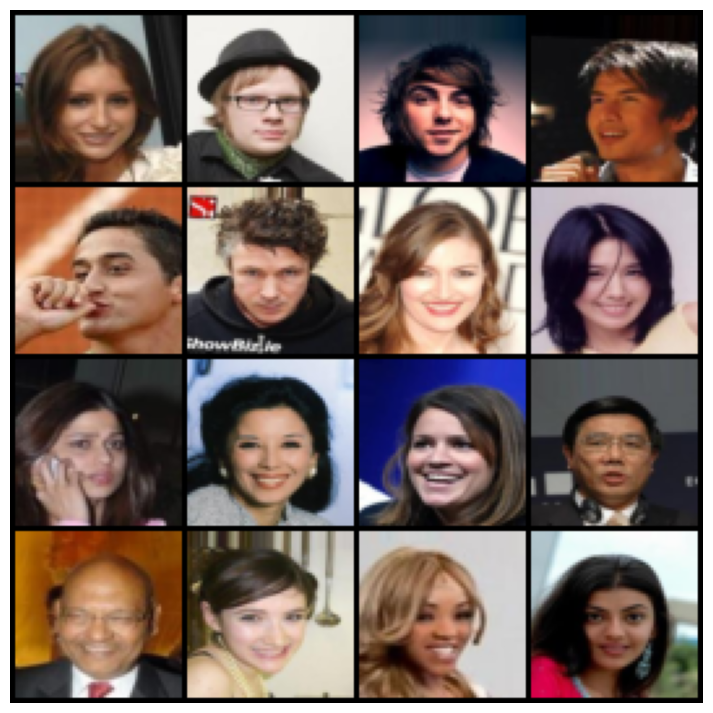

In [ ]:
# Visualize a few images
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

# Load a batch of images
data_iter = iter(train_loader)
images, labels = next(data_iter)

images = images[:16]

# Unnormalize the images
images = images * 0.5 + 0.5  # Rescale back to [0, 1]

# Make a grid from the batch
grid = vutils.make_grid(images, nrow=4, padding=2, normalize=False)

# Convert the grid to a numpy array
grid_np = grid.numpy()

# Transpose the array for display with matplotlib (C, H, W) to (H, W, C)
grid_np = np.transpose(grid_np, (1, 2, 0))

# Display the grid of images
plt.figure(figsize=(9, 9))  # Size of the figure
plt.imshow(grid_np)
plt.axis('off')
plt.show()

In [ ]:
# Generator Model

class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.ConvTranspose2d(512, 216, 4, 2, 1, bias=False),
        nn.BatchNorm2d(216),
        nn.ReLU(),
        nn.ConvTranspose2d(216, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
        nn.Tanh(),
    )

  def forward(self, input):
    input = input.view(-1, 100, 1, 1)  # Reshape from [batch_size, 100] to [batch_size, 100, 1, 1]
    return self.model(input)

In [ ]:
# Discriminator Model

class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Conv2d(3, 64, 4, 2, 1, bias=False),
        nn.ReLU(),
        nn.Conv2d(64, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(256, 512, 4, 2, 1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(512, 1, 4, 1, 0, bias=False),
        nn.Sigmoid(),
    )

  def forward(self, input):
    # Reshape the input tensor to have 4 dimensions
    input = input.view(-1, 3, 64, 64)  # Assuming 3 channels and 64x64 image size
    return self.model(input).view(-1, 1).squeeze(1)

In [ ]:
import torch.nn.functional as F

def train(n_epochs, train_set, batch_size, dis, gen, criterion_gan, criterion_pixel, optimizer_d, optimizer_g):
    for epoch in range(n_epochs):
        for i, (real_images, _) in enumerate(train_set):
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            # Train Discriminator
            optimizer_d.zero_grad()

            # Real images
            real_output = dis(real_images)
            real_labels = torch.ones_like(real_output, device=device, dtype=torch.float32)
            loss_real = F.binary_cross_entropy(real_output, real_labels, reduction='sum')

            # Fake images
            noise = torch.randn(batch_size, 100, 1, 1, device=device)
            fake_images = gen(noise)
            fake_output = dis(fake_images.detach())
            fake_labels = torch.zeros_like(fake_output, device=device, dtype=torch.float32)
            loss_fake = F.binary_cross_entropy(fake_output, fake_labels, reduction='sum')

            loss_d = (loss_real + loss_fake) / batch_size
            loss_d.backward()
            optimizer_d.step()

            # Train Generator
            optimizer_g.zero_grad()
            fake_output = dis(fake_images)
            real_labels = torch.ones_like(fake_output, device=device, dtype=torch.float32)
            loss_g = F.binary_cross_entropy(fake_output, real_labels, reduction='sum') / batch_size
            loss_g.backward()
            optimizer_g.step()

            # Print losses
            if i % 100 == 0:
                print(f"Epoch [{epoch}/{n_epochs}] Batch [{i}/{len(train_set)}] Loss D: {loss_d.item():.4f} Loss G: {loss_g.item():.4f}")

In [ ]:
dis = Discriminator().to(device)
gen = Generator().to(device)

In [ ]:
import torch.optim as optim

# Hyperparameters
batch_size = 128
lr = 0.0002
n_epochs = 50

# Loss functions
criterion_gan = nn.BCELoss()
criterion_pixel = nn.L1Loss()

# Optimizers
optimizer_d = optim.Adam(dis.parameters(), lr=lr)
optimizer_g = optim.Adam(gen.parameters(), lr=lr)

In [ ]:
train(10, train_set, batch_size, dis, gen, criterion_gan, criterion_pixel, optimizer_d, optimizer_g)

Epoch [0/10] Batch [0/162770] Loss D: 0.6793 Loss G: 7.9196
Epoch [0/10] Batch [100/162770] Loss D: 0.0155 Loss G: 6.7721
Epoch [0/10] Batch [200/162770] Loss D: 0.0447 Loss G: 6.8100
Epoch [0/10] Batch [300/162770] Loss D: 0.0001 Loss G: 11.2304
Epoch [0/10] Batch [400/162770] Loss D: 0.0605 Loss G: 6.7072
Epoch [0/10] Batch [500/162770] Loss D: 0.1918 Loss G: 4.5572
Epoch [0/10] Batch [600/162770] Loss D: 0.3922 Loss G: 6.1290
Epoch [0/10] Batch [700/162770] Loss D: 0.0108 Loss G: 6.0708
Epoch [0/10] Batch [800/162770] Loss D: 0.0115 Loss G: 6.1964
Epoch [0/10] Batch [900/162770] Loss D: 0.1619 Loss G: 3.1020
Epoch [0/10] Batch [1000/162770] Loss D: 0.9266 Loss G: 3.3191
Epoch [0/10] Batch [1100/162770] Loss D: 1.8359 Loss G: 3.3480
Epoch [0/10] Batch [1200/162770] Loss D: 0.0394 Loss G: 4.0143
Epoch [0/10] Batch [1300/162770] Loss D: 0.4817 Loss G: 3.0203
Epoch [0/10] Batch [1400/162770] Loss D: 0.2566 Loss G: 5.1876
Epoch [0/10] Batch [1500/162770] Loss D: 0.6302 Loss G: 4.4653
Epo

In [ ]:
# Example

gen = Generator().to(device)
gen.load_state_dict(torch.load("generator.pth"))
gen.eval()

# Generate a batch of noise tensors
noise = torch.randn(16, 100, 1, 1, device=device)

# Generate images from the noise tensors
with torch.no_grad():
    generated_images = gen(noise)

# Create a 4x4 grid of generated images
img_grid = vutils.make_grid(generated_images.detach().cpu(), normalize=True, nrow=4)

# Convert the image grid to a NumPy array
img_grid_np = img_grid.permute(1, 2, 0).numpy()

# Display the image grid
plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(img_grid_np, (1, 0, 2)))
plt.axis('off')
plt.show()